# Approximating data using deep learning

Note that for this approach we based ourselves on the Standford lecture notes on convolutional neural networks for visual recognition.

This lecture is open source and can be found on http://cs231n.github.io/ 

In [31]:
# Clean up the memory
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import gc

import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [17]:
DATA_FOLDER = "data/"
SESSION_FOLDER = "session/"

TRAIN_SET_PERC = 0.9

In [3]:
def save_session(filename, nb_iterations = -1):
    '''
    Saves a seesion in a file with the given filename
    A number of iterations can also be given 
    :param : String
    :param : int
    '''
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    if nb_iterations >= 0:
        saver.save(sess, SESSION_FOLDER + filename, global_step=nb_iterations)
    else:
        saver.save(sess, SESSION_FOLDER + filename)
        
    print("Session saved with filename {}.".format(filename))
    
def restore_session(filename):
    '''
    Restores a tensorflow session stored in the given filename
    After the call of this function, the sessios's variable will be available again
    :param : String
    '''
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph(SESSION_FOLDER + filename + '.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        
def garbage_collection():
    '''
    Calls garbage collection to clean unused memory
    '''
    gc.collect()

In [4]:
def rmse(pred, real, loop = True):
    '''
    Computes RMSE between predictions and real values
    :param : float[]
    :param : float[]
    :return : float
    '''
    if len(pred) != len(real):
        print("RMSE Error : Predictions and real values arrays do not have the same length, aborting.")
        return None
    
    if loop:
        mse = 0
        for i in range(len(pred)):
            mse += (pred[i] - real[i])**2
        return math.sqrt(2*mse/len(pred))
    else:
        # The creation of the array may produce memory error
        err = pred - real
        mse = err.T @ err
        return math.sqrt(2 * mse / len(pred))

In [5]:
def plot_history(history):
    '''
    Plots the history of the training error
    Usefull 
    '''
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

## Preparing the data



In [6]:
# Use non normalized feature matrix
# For now best results are given with this one
#X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")

# Use normalized feature matrix
################################################################################################
# Careful                                                                                      #
# Normally, normalisation should be done one each train/val/test matrices. It is not done here #
################################################################################################
X = np.load(DATA_FOLDER + "feature_mat_radial_compression_normalized.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [20]:
# Prepare train and test set

train_set_size = int(len(X) * TRAIN_SET_PERC)
X_train = X[: train_set_size]
X_test = X[train_set_size:]
y_train = y[: train_set_size]
y_test = y[train_set_size :]

In [7]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


# Single neural network model approach

First we will do a single model approach, the goal is to see quickly how we can build a model using neural networks and how well it does. 

In [21]:
# Clean up as much memory as possible before starting
garbage_collection()

# Prepare model 
model = tf.keras.Sequential([
    # Assuming each layer represent a link between particules, we begin with 4 layers
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    # Last layer represent the electromagnetic shielding, our prediction
    layers.Dense(1, activation='relu')])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',
              # Note that the accuracy metric is useless but it doesn't compile when trying to use RMSE.
              metrics=['mae'])

In [22]:
# We train the model on our data
# Number of epochs the network should run through
EPOCHS = 200
# Size of the batch for optimization
BATCH_SIZE = 32
# Set up validation split
VALIDATION_SPLIT = 0.2
# The patience parameter is the amount of epochs to check for improvement
# This will avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split = VALIDATION_SPLIT, \
          callbacks=[early_stop])
model.summary()

Train on 21635 samples, validate on 5409 samples
Epoch 1/200
21635/21635 [==============================] - 7s 345us/step - loss: 19.1277 - mean_absolute_error: 2.5579 - val_loss: 5.3781 - val_mean_absolute_error: 1.6841
Epoch 2/200
21635/21635 [==============================] - 6s 289us/step - loss: 2.8471 - mean_absolute_error: 1.1796 - val_loss: 4.3331 - val_mean_absolute_error: 1.4901
Epoch 3/200
21635/21635 [==============================] - 6s 278us/step - loss: 1.8293 - mean_absolute_error: 0.9594 - val_loss: 3.9719 - val_mean_absolute_error: 1.4241
Epoch 4/200
21635/21635 [==============================] - 6s 289us/step - loss: 1.5047 - mean_absolute_error: 0.8830 - val_loss: 3.3000 - val_mean_absolute_error: 1.2985
Epoch 5/200
21635/21635 [==============================] - 6s 293us/step - loss: 1.3501 - mean_absolute_error: 0.8496 - val_loss: 3.4294 - val_mean_absolute_error: 1.3413
Epoch 6/200
21635/21635 [==============================] - 6s 294us/step - loss: 1.2400 - mean_

21635/21635 [==============================] - 6s 279us/step - loss: 0.1005 - mean_absolute_error: 0.2419 - val_loss: 1.1475 - val_mean_absolute_error: 0.7304
Epoch 49/200
21635/21635 [==============================] - 6s 281us/step - loss: 0.1083 - mean_absolute_error: 0.2542 - val_loss: 1.1159 - val_mean_absolute_error: 0.7206
Epoch 50/200
21635/21635 [==============================] - 6s 282us/step - loss: 0.1155 - mean_absolute_error: 0.2622 - val_loss: 1.0711 - val_mean_absolute_error: 0.7143
Epoch 51/200
21635/21635 [==============================] - 6s 279us/step - loss: 0.0982 - mean_absolute_error: 0.2412 - val_loss: 1.0252 - val_mean_absolute_error: 0.6965
Epoch 52/200
21635/21635 [==============================] - 6s 280us/step - loss: 0.0902 - mean_absolute_error: 0.2305 - val_loss: 1.0963 - val_mean_absolute_error: 0.7526
Epoch 53/200
21635/21635 [==============================] - 6s 280us/step - loss: 0.0987 - mean_absolute_error: 0.2424 - val_loss: 1.0511 - val_mean_abso

Epoch 96/200
21635/21635 [==============================] - 6s 289us/step - loss: 0.0382 - mean_absolute_error: 0.1471 - val_loss: 0.8188 - val_mean_absolute_error: 0.6215
Epoch 97/200
21635/21635 [==============================] - 7s 311us/step - loss: 0.0509 - mean_absolute_error: 0.1491 - val_loss: 0.8312 - val_mean_absolute_error: 0.6355
Epoch 98/200
21635/21635 [==============================] - 6s 289us/step - loss: 0.0807 - mean_absolute_error: 0.1620 - val_loss: 0.7539 - val_mean_absolute_error: 0.5901
Epoch 99/200
21635/21635 [==============================] - 6s 293us/step - loss: 0.5009 - mean_absolute_error: 0.1774 - val_loss: 0.7897 - val_mean_absolute_error: 0.6073
Epoch 100/200
21635/21635 [==============================] - 6s 291us/step - loss: 0.0319 - mean_absolute_error: 0.1317 - val_loss: 0.7913 - val_mean_absolute_error: 0.6049
Epoch 101/200
21635/21635 [==============================] - 6s 285us/step - loss: 0.0287 - mean_absolute_error: 0.1293 - val_loss: 0.7708 

21635/21635 [==============================] - 6s 282us/step - loss: 0.0235 - mean_absolute_error: 0.1138 - val_loss: 0.6586 - val_mean_absolute_error: 0.5533
Epoch 144/200
21635/21635 [==============================] - 6s 281us/step - loss: 0.0216 - mean_absolute_error: 0.1054 - val_loss: 0.7154 - val_mean_absolute_error: 0.5833
Epoch 145/200
21635/21635 [==============================] - 6s 284us/step - loss: 0.0773 - mean_absolute_error: 0.1202 - val_loss: 0.6796 - val_mean_absolute_error: 0.5756
Epoch 146/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0248 - mean_absolute_error: 0.1156 - val_loss: 0.6621 - val_mean_absolute_error: 0.5563
Epoch 147/200
21635/21635 [==============================] - 6s 284us/step - loss: 0.0228 - mean_absolute_error: 0.1096 - val_loss: 0.6612 - val_mean_absolute_error: 0.5531
Epoch 148/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0292 - mean_absolute_error: 0.1127 - val_loss: 0.6585 - val_mean

21635/21635 [==============================] - 6s 282us/step - loss: 0.0164 - mean_absolute_error: 0.0940 - val_loss: 0.6385 - val_mean_absolute_error: 0.5495
Epoch 191/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0158 - mean_absolute_error: 0.0924 - val_loss: 0.6596 - val_mean_absolute_error: 0.5761
Epoch 192/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0169 - mean_absolute_error: 0.0963 - val_loss: 0.6482 - val_mean_absolute_error: 0.5624
Epoch 193/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0182 - mean_absolute_error: 0.0995 - val_loss: 0.6390 - val_mean_absolute_error: 0.5430
Epoch 194/200
21635/21635 [==============================] - 6s 282us/step - loss: 0.0179 - mean_absolute_error: 0.0977 - val_loss: 0.6501 - val_mean_absolute_error: 0.5488
Epoch 195/200
21635/21635 [==============================] - 6s 283us/step - loss: 0.0173 - mean_absolute_error: 0.0954 - val_loss: 0.6600 - val_mean

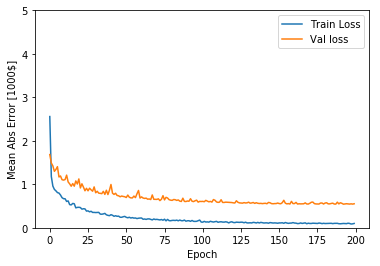

In [24]:
plot_history(history)

In [25]:
result = model.predict(X_test, batch_size=32)
rmse(result, y_test)

1.1305755100837624

## Results

For the following model :
    - 4 hidden layers of 64 neurons - relu activation.
    - A result layer of 1 neuron - relu activation.
    - Early stopping callback
    - Test split of 0.2
    - Using AdamOptimizer gives best results.
    - No cross validation.
    
Network size :
- $4*64 + 1 = 257$ neurons (biases)
- $30049*64 + 64*64 + 64*64 + 64 = 1931392$ weights
- Total of $1931649$ learnable parameters (almost 2 millions)

With the above, we reached a RMSE of 0.5. But this is without separating the data into train and test set. This can lead to overfitting. Now we need to ensure that we are not overfitting.

For this we will test 2 solutions :

### Change our implementation to add regulizer that will avoid this overfitting

### Cross validation over multiple models